In [1]:
import torch 
from Ford_dataset import SatGrdDatasetFord, train_logs, train_logs_img_inds, test_logs, test_logs_img_inds
from torch.utils.data import DataLoader

logs_start = 0; logs_end = 5
range_lat = 20; range_lot=20; rotation_range =20; #meters, meters, degress
train_set  = SatGrdDatasetFord(logs=train_logs[logs_start:logs_end], logs_img_inds=train_logs_img_inds[logs_start:logs_end], mode='train')
val_set = SatGrdDatasetFord(logs=test_logs[logs_start:logs_end], logs_img_inds=test_logs_img_inds[logs_start:logs_end], mode='val')

train_loader = DataLoader(train_set, batch_size=4, shuffle=True, num_workers=4, prefetch_factor=1)
val_loader = DataLoader(val_set, batch_size=4, shuffle=True, num_workers=4, prefetch_factor=1)

print(f'len train_set {len(train_loader)}, len val_set {len(val_loader)}')


len train_set 7937, len val_set 3585


In [ ]:
from matplotlib import pyplot as plt 

img_idx = 0 
sat_img, grd_imgs, gt_shift_u, gt_shift_v, theta, grd_names, sat_img_no_rot, mask_dt_xy, dt_xy = train_set[img_idx]

plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.title(f'displacment of the vehicle from ground truth \n v = {gt_shift_v:.2f} u = {gt_shift_u:.2f}  th = {theta:.2f}')
plt.imshow(sat_img.permute([1,2,0]))

plt.subplot(2,2,2)
plt.title('no rot no trans')
plt.imshow(sat_img_no_rot.permute([1,2,0]))
plt.show()



In [ ]:
from Ford_dataset import get_xy_map

def visualize_dt_xy(sat_img, sat_img_no_rot, dt_xy_mask, dt_xy):
    # torch.manual_seed(123)
    """
    shift_x, shift_y, theta [-1,1] -> numpy.random
    """
    meters_per_pixel = 0.22
    sidelength_orig = 512

    sidelength = dt_xy_mask.shape[-1]
    xy_map = get_xy_map(sidelength)

    idxs = torch.randint(0,sidelength*sidelength-1,(10,))

    sc_x = xy_map.view(2,-1)[0,idxs]*sidelength_orig+sidelength_orig//2
    sc_y = xy_map.view(2,-1)[1,idxs]*sidelength_orig+sidelength_orig//2

    sc_x_dt = dt_xy.view(2,-1)[0,idxs]*sidelength_orig
    sc_y_dt = dt_xy.view(2,-1)[1,idxs]*sidelength_orig


    plt.figure(figsize=(20,20))
    plt.subplot(2,2,1)
    plt.title(f'displacment of the vehicle from ground truth \n v = {gt_shift_v:.2f} u = {gt_shift_u:.2f}  th = {theta:.2f}')
    plt.imshow((sat_img).permute([1,2,0]), cmap='hot')
    plt.subplot(2,2,2)
    plt.title('no rot no trans')
    plt.imshow(sat_img_no_rot.permute([1,2,0]))


    dt_xy_mask = torch.nn.functional.interpolate(dt_xy_mask[None, None, ...].float(), size=(512, 512), mode='nearest')[0,0]
    plt.subplot(2,2,3)
    plt.imshow((dt_xy_mask*sat_img).permute([1,2,0]), cmap='hot')
    plt.imshow((dt_xy_mask*sat_img).permute([1,2,0]), cmap='hot')
    plt.scatter(sc_y, sc_x, s=10, color = (0,0,1))
    plt.scatter(sc_y+0.2*sc_y_dt, sc_x+0.2*sc_x_dt, s=10, color=(0.2,0,0.8))
    plt.scatter(sc_y+0.4*sc_y_dt, sc_x+0.4*sc_x_dt, s=10, color=(0.4,0,0.6))
    plt.scatter(sc_y+0.6*sc_y_dt, sc_x+0.6*sc_x_dt, s=10, color=(0.6,0,0.4))
    plt.scatter(sc_y+0.8*sc_y_dt, sc_x+0.8*sc_x_dt, s=10, color=(0.8,0,0.2))
    plt.scatter(sc_y+1.0*sc_y_dt, sc_x+1.0*sc_x_dt, s=10, color=(1.0,0,0.0))
    
    plt.subplot(2,2,4)
    plt.imshow(sat_img_no_rot.permute([1,2,0]) , cmap='hot')
    plt.scatter(sc_y, sc_x, s=10, color = (0,0,1))
    plt.scatter(sc_y+0.2*sc_y_dt, sc_x+0.2*sc_x_dt, s=10, color=(0.2,0,0.8))
    plt.scatter(sc_y+0.4*sc_y_dt, sc_x+0.4*sc_x_dt, s=10, color=(0.4,0,0.6))
    plt.scatter(sc_y+0.6*sc_y_dt, sc_x+0.6*sc_x_dt, s=10, color=(0.6,0,0.4))
    plt.scatter(sc_y+0.8*sc_y_dt, sc_x+0.8*sc_x_dt, s=10, color=(0.8,0,0.2))
    plt.scatter(sc_y+1.0*sc_y_dt, sc_x+1.0*sc_x_dt, s=10, color=(1.0,0,0.0))

    
print((gt_shift_v, gt_shift_u, theta))
visualize_dt_xy(sat_img, sat_img_no_rot, mask_dt_xy, dt_xy)


In [2]:
# net
import time 
import torch.nn as nn 
from models import UnetFeatures, Image2Token, SelfAttention, CrossAttention, MLP, Token2Image, Block
from torch.nn import functional as F

device = 'cuda'

torch.manual_seed(0)
n_emb = 64*12; n_heads = 12; C=512; H=64; W=64


class Model(nn.Module):
    def __init__(self):
        super().__init__()

        self.img_encoder = UnetFeatures()
        self.img2token = Image2Token(C, n_emb, H*W)

        self.block1 = Block(n_emb, n_heads)
        self.block2 = Block(n_emb, n_heads)

        self.output_layer = nn.Linear(n_emb, 4)
        self.token2img = Token2Image(4, H, W)

    def forward(self, sat_img, sat_img_no_rot):
        B, _, _, _ = sat_img.shape
        encod_feat = self.img_encoder( torch.cat((sat_img, sat_img_no_rot), dim = 0) )
        sat_img_feat, sat_img_no_rot_feat = torch.split(encod_feat, B, dim=0)

        sat_img_feat = self.img2token(sat_img_feat)
        sat_img_no_rot_feat = self.img2token(sat_img_no_rot_feat)

        # _, C, H, W = sat_img_feat.shape
        # sat_img_feat = sat_img_feat.view(B, C, H*W).transpose(1,2) #B, H*W, C
        # sat_img_no_rot_feat = sat_img_no_rot_feat.view(B, C, H*W)

        # out = (sat_img_feat @ sat_img_no_rot_feat) #B, H*W, H*W
        # out = self.ln(out)

        x = self.block1(sat_img_feat, sat_img_no_rot_feat)#B, H*W, n_emb
        x = self.block2(x, sat_img_no_rot_feat)#B, H*W, n_emb

        x = self.output_layer(x) #B, H*W, 4
        x = self.token2img(x) #B,4,H,W

        return x


def eval_model(model, val_loader):
    model.eval()
    loss_sum = 0

    for sat_img, grd_imgs, gt_shift_u, gt_shift_v, theta, grd_names, sat_img_no_rot, mask_dt_xy, dt_xy in val_loader:
        sat_img_no_rot = sat_img_no_rot.to(device); sat_img = sat_img.to(device)
        mask_dt_xy = mask_dt_xy.to(device) ;dt_xy = dt_xy.to(device)

        with torch.no_grad():
            out = model(sat_img, sat_img_no_rot)
            ce =  F.cross_entropy(out[:,:2, :, :], mask_dt_xy)  
            rmse = torch.mean( ( (dt_xy - F.tanh(out[:,2:, :, :])) **2 ) * mask_dt_xy.unsqueeze(1).float()) ** 0.5
            loss = ce + 5 * rmse
            loss_sum += loss.item()
            # print(loss, ce, rmse)

    model.train()
    return loss_sum/len(val_loader)

def get_lr(epoch):
    if epoch >=0 and epoch<1:
        lr = 3e-4
    elif epoch >=1 and epoch<2:
        lr = 1e-4
    elif epoch >=2:
        lr = 3e-5
    return lr


torch.set_float32_matmul_precision('high')
model = Model().to(device)
# model.load_state_dict(torch.load('model_trans.pth'))
# model = torch.compile(model)


loss_train = []
loss_val = []
epochs = 3


for epoch in range(epochs): 
    loop = 0
    train_loss_sum = 0
    train_loss_rmse_sum = 0
    train_loss_ce_sum = 0
    lr = get_lr(epoch)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

    for sat_img, grd_imgs, gt_shift_u, gt_shift_v, theta, grd_names, sat_img_no_rot, mask_dt_xy, dt_xy in train_loader:
        sat_img_no_rot = sat_img_no_rot.to(device); sat_img = sat_img.to(device)
        mask_dt_xy = mask_dt_xy.to(device) ;dt_xy = dt_xy.to(device)

        optimizer.zero_grad()
        # time_start = time.time()
        out = model(sat_img, sat_img_no_rot)
        ce =  F.cross_entropy(out[:,:2, :, :], mask_dt_xy)  
        rmse = torch.mean( ( (dt_xy - F.tanh(out[:,2:, :, :])) **2 ) * mask_dt_xy.unsqueeze(1).float()) ** 0.5
        loss = ce + 5 * rmse

        
        loss.backward()
        optimizer.step()

        train_loss_sum += loss.item()
        train_loss_rmse_sum += rmse.item()
        train_loss_ce_sum += ce.item()
        # torch.cuda.synchronize()
        # print(f'time per step {time.time()-time_start:.2f}')
        if loop%100 == 0:
            print(f'epoch {epoch} loop {loop} avg_loss = {train_loss_sum/(loop+1)} avg_loss_ce = {train_loss_ce_sum/(loop+1)} avg_loss_rmse = {train_loss_rmse_sum/(loop+1)}')#, f'time perstep {time.time()-time_start}')
        loop+=1
    
    loss_train.append(train_loss_sum/len(train_loader))
    loss_val.append(eval_model(model, val_loader))

    print(f'train_loss = {loss_train[-1]} val_loss = {loss_val[-1]}')

# torch.save(model.state_dict(), 'model_trans.pth')
# first run 
# epoch 0 lr = 3e-4 : in the beggining the loss was decressing for the first 3000 iterations and sudenly started incressing and got stuck at a 1.1 
# probably needs a lower starting lr or warp up 
# used a starting lr = 1e-4 for the next run 

# second run 
# epoch 0 lr = 1e-4
# epoch 1 lr = 3e-5
# epoch 2 lr = 1e-5
# final results 
# train_loss = 0.223720996298109 val_loss = 0.2586872426494229
# training time 502 minutes 

# third run, loaded weights from second run 
# epoch 0 lr = 3e-4
# epoch 1 lr = 1e-4
# epoch 2 lr = 3e-5
# final results 
# train_loss = 0.15259322583866883 val_loss = 0.1835602030095695
# training time 534 minutes 



c:\Users\dimitris\Desktop\MyFiles\diplomatikh\pytorch-tensorflow\pytorch\Cross-View-Localization\PixelMatching\models.py:203: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  out = torch.nn.functional.scaled_dot_product_attention(q, k, v) # (B, nh, T, hs)


epoch 0 loop 0 avg_loss = 5.64943790435791 avg_loss_ce = 1.9937818050384521 avg_loss_rmse = 0.7311312556266785
epoch 0 loop 100 avg_loss = 5.569187457018559 avg_loss_ce = 1.0481099961417737 avg_loss_rmse = 0.9042154951850967
epoch 0 loop 200 avg_loss = 5.232613414081175 avg_loss_ce = 0.7205916349567584 avg_loss_rmse = 0.9024043578413589
epoch 0 loop 300 avg_loss = 5.120946016026494 avg_loss_ce = 0.6078312347497655 avg_loss_rmse = 0.9026229577603134
epoch 0 loop 400 avg_loss = 5.067033535821777 avg_loss_ce = 0.5449373416621192 avg_loss_rmse = 0.9044192388765235
epoch 0 loop 500 avg_loss = 5.037357334129349 avg_loss_ce = 0.5104535749691451 avg_loss_rmse = 0.905380751677378
epoch 0 loop 600 avg_loss = 5.008027895516444 avg_loss_ce = 0.4843602604457424 avg_loss_rmse = 0.9047335272224096
epoch 0 loop 700 avg_loss = 4.98731843823203 avg_loss_ce = 0.4631413526184719 avg_loss_rmse = 0.9048354174203097
epoch 0 loop 800 avg_loss = 4.972154711962639 avg_loss_ce = 0.44801358017284476 avg_loss_rmse

In [40]:

def visualize_dt_xy(sat_img, sat_img_no_rot, dt_xy_mask, dt_xy, mask_dt_xy_pred, dt_xy_pred):
    # torch.manual_seed(123)
    """
    shift_x, shift_y, theta [-1,1] -> numpy.random
    """
    meters_per_pixel = 0.22
    sidelength_orig = 512

    sidelength = dt_xy_mask.shape[-1]
    xy_map = get_xy_map(sidelength)

    idxs = torch.randint(0,sidelength*sidelength-1,(30,))



    sc_x = xy_map.view(2,-1)[0,idxs]*sidelength_orig+sidelength_orig//2 
    sc_y = xy_map.view(2,-1)[1,idxs]*sidelength_orig+sidelength_orig//2 


    sc_x_dt = dt_xy.view(2,-1)[0,idxs]*sidelength_orig
    sc_y_dt = dt_xy.view(2,-1)[1,idxs]*sidelength_orig


    plt.figure(figsize=(20,20))
    # plt.subplot(2,2,1)
    # plt.title(f'displacment of the vehicle from ground truth \n v = {gt_shift_v:.2f} u = {gt_shift_u:.2f}  th = {theta:.2f}')
    # plt.imshow((sat_img).permute([1,2,0]), cmap='hot')
    # plt.subplot(2,2,2)
    # plt.title('no rot no trans')
    # plt.imshow(sat_img_no_rot.permute([1,2,0]))


    dt_xy_mask = torch.nn.functional.interpolate(dt_xy_mask[None, None, ...].float(), size=(512, 512), mode='nearest')[0,0]
    plt.subplot(2,2,1)
    plt.imshow((dt_xy_mask*sat_img).permute([1,2,0]), cmap='hot')
    plt.scatter(sc_y, sc_x, s=10, color = (0,0,1))
    plt.scatter(sc_y+0.2*sc_y_dt, sc_x+0.2*sc_x_dt, s=10, color=(0.2,0,0.8))
    plt.scatter(sc_y+0.4*sc_y_dt, sc_x+0.4*sc_x_dt, s=10, color=(0.4,0,0.6))
    plt.scatter(sc_y+0.6*sc_y_dt, sc_x+0.6*sc_x_dt, s=10, color=(0.6,0,0.4))
    plt.scatter(sc_y+0.8*sc_y_dt, sc_x+0.8*sc_x_dt, s=10, color=(0.8,0,0.2))
    plt.scatter(sc_y+1.0*sc_y_dt, sc_x+1.0*sc_x_dt, s=10, color=(1.0,0,0.0))
    
    plt.subplot(2,2,2)
    plt.imshow(sat_img_no_rot.permute([1,2,0]) , cmap='hot')
    plt.scatter(sc_y, sc_x, s=10, color = (0,0,1))
    plt.scatter(sc_y+0.2*sc_y_dt, sc_x+0.2*sc_x_dt, s=10, color=(0.2,0,0.8))
    plt.scatter(sc_y+0.4*sc_y_dt, sc_x+0.4*sc_x_dt, s=10, color=(0.4,0,0.6))
    plt.scatter(sc_y+0.6*sc_y_dt, sc_x+0.6*sc_x_dt, s=10, color=(0.6,0,0.4))
    plt.scatter(sc_y+0.8*sc_y_dt, sc_x+0.8*sc_x_dt, s=10, color=(0.8,0,0.2))
    plt.scatter(sc_y+1.0*sc_y_dt, sc_x+1.0*sc_x_dt, s=10, color=(1.0,0,0.0))


    sc_x_dt_pred = dt_xy_pred.view(2,-1)[0,idxs]*sidelength_orig
    sc_y_dt_pred = dt_xy_pred.view(2,-1)[1,idxs]*sidelength_orig
    
    mask_dt_xy_pred = torch.nn.functional.interpolate(mask_dt_xy_pred[None, None, ...].float(), size=(512, 512), mode='nearest')[0,0]

    plt.subplot(2,2,3)
    plt.imshow((mask_dt_xy_pred*sat_img).permute([1,2,0]), cmap='hot')
    plt.imshow((mask_dt_xy_pred*sat_img).permute([1,2,0]), cmap='hot')
    plt.scatter(sc_y, sc_x, s=10, color = (0,0,1))
    plt.scatter(sc_y+0.2*sc_y_dt_pred, sc_x+0.2*sc_x_dt_pred, s=10, color=(0.2,0,0.8))
    plt.scatter(sc_y+0.4*sc_y_dt_pred, sc_x+0.4*sc_x_dt_pred, s=10, color=(0.4,0,0.6))
    plt.scatter(sc_y+0.6*sc_y_dt_pred, sc_x+0.6*sc_x_dt_pred, s=10, color=(0.6,0,0.4))
    plt.scatter(sc_y+0.8*sc_y_dt_pred, sc_x+0.8*sc_x_dt_pred, s=10, color=(0.8,0,0.2))
    plt.scatter(sc_y+1.0*sc_y_dt_pred, sc_x+1.0*sc_x_dt_pred, s=10, color=(1.0,0,0.0))
    
    plt.subplot(2,2,4)
    plt.imshow(sat_img_no_rot.permute([1,2,0]) , cmap='hot')
    plt.scatter(sc_y, sc_x, s=10, color = (0,0,1))
    plt.scatter(sc_y+0.2*sc_y_dt_pred, sc_x+0.2*sc_x_dt_pred, s=10, color=(0.2,0,0.8))
    plt.scatter(sc_y+0.4*sc_y_dt_pred, sc_x+0.4*sc_x_dt_pred, s=10, color=(0.4,0,0.6))
    plt.scatter(sc_y+0.6*sc_y_dt_pred, sc_x+0.6*sc_x_dt_pred, s=10, color=(0.6,0,0.4))
    plt.scatter(sc_y+0.8*sc_y_dt_pred, sc_x+0.8*sc_x_dt_pred, s=10, color=(0.8,0,0.2))
    plt.scatter(sc_y+1.0*sc_y_dt_pred, sc_x+1.0*sc_x_dt_pred, s=10, color=(1.0,0,0.0))


tensor(0.1134, device='cuda:0')


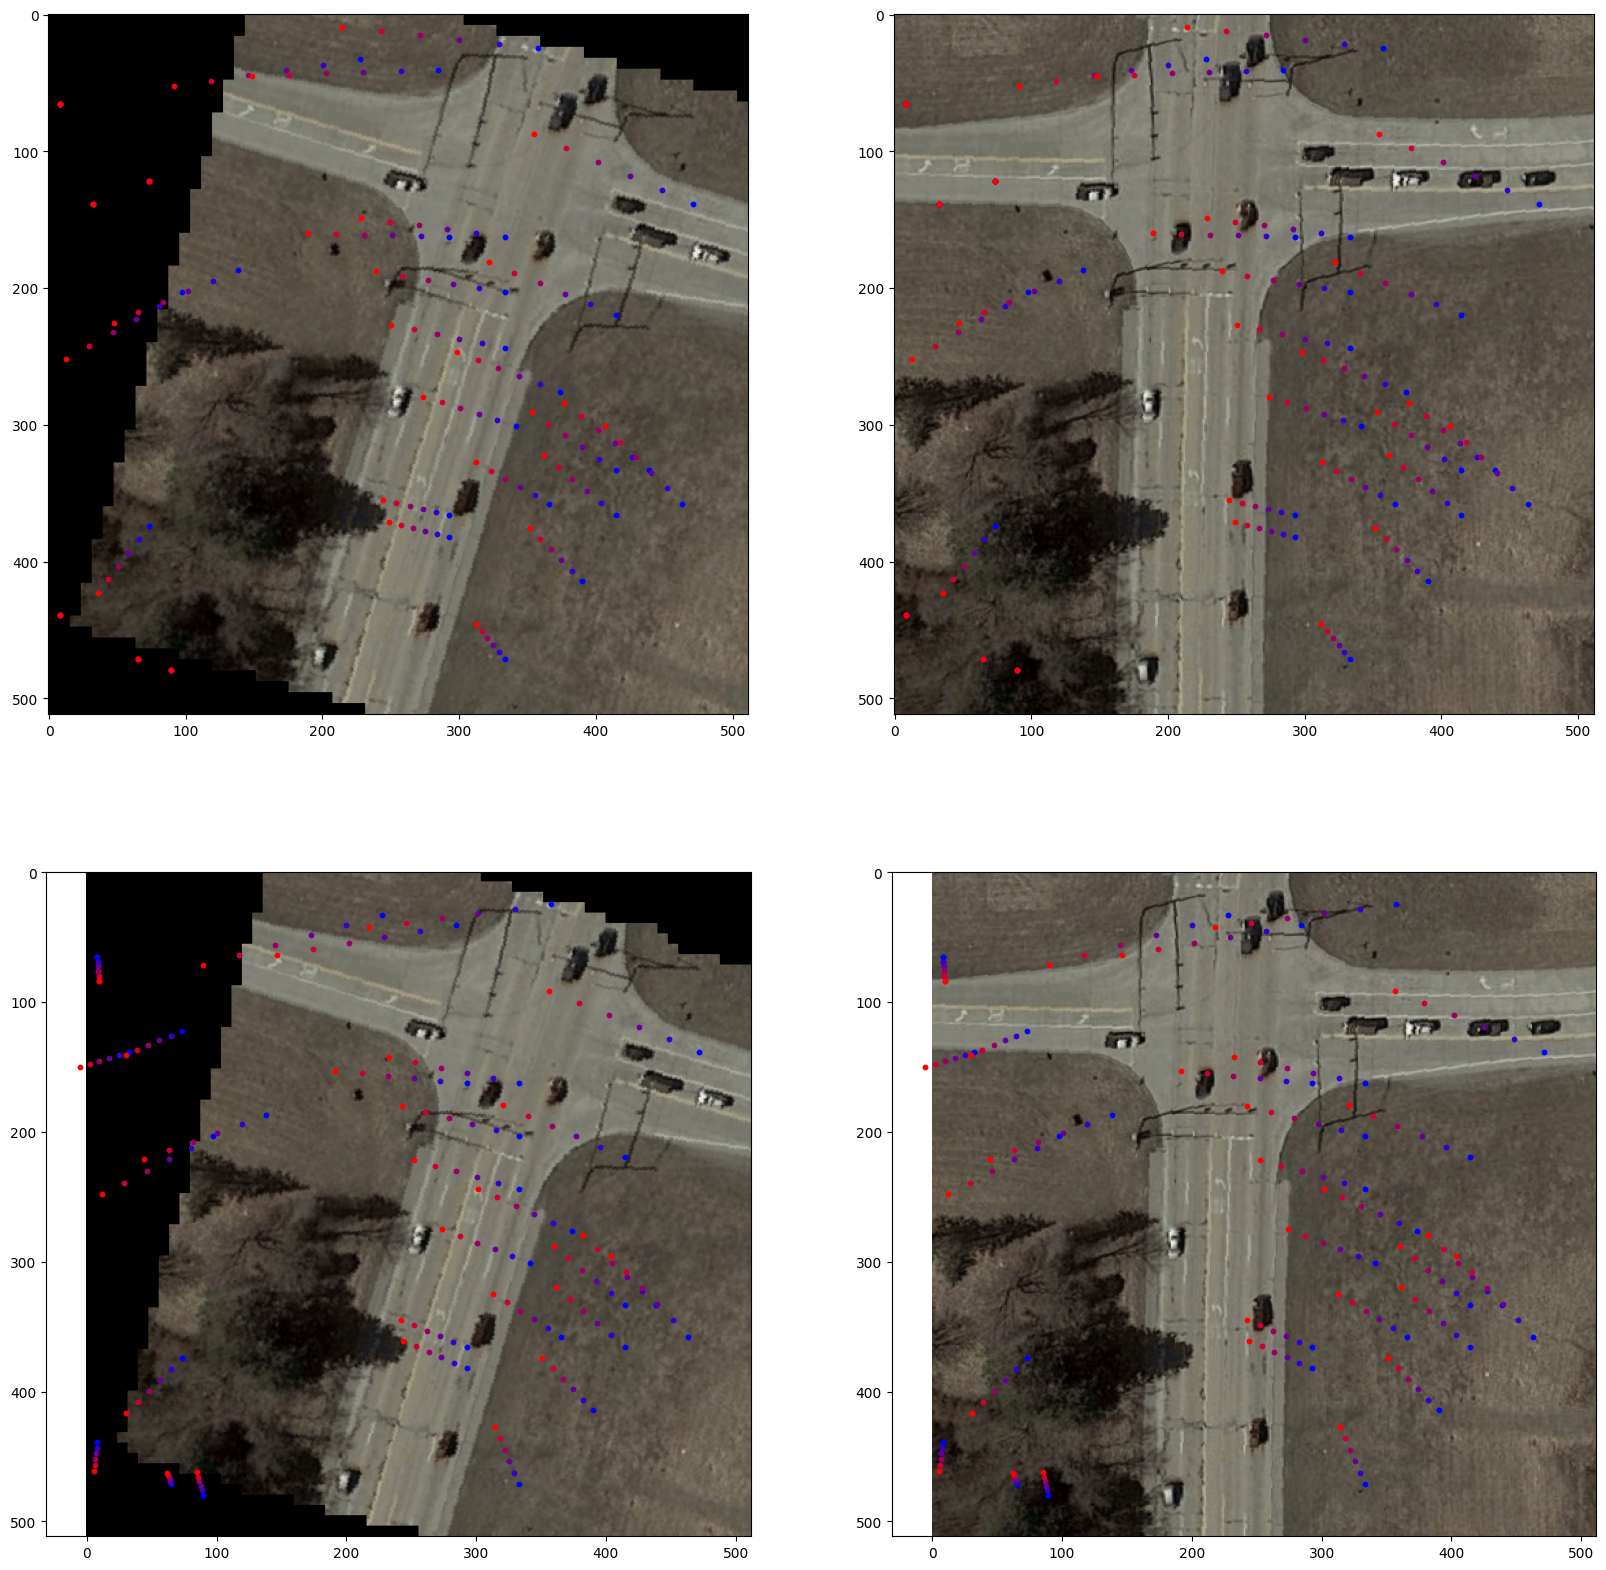

In [88]:
img_idx = 7622 
sat_img, grd_imgs, gt_shift_u, gt_shift_v, theta, grd_names, sat_img_no_rot, mask_dt_xy, dt_xy = train_set[img_idx]
sat_img = sat_img.to(device)[None, ...]; sat_img_no_rot =sat_img_no_rot.to(device)[None, ...]; mask_dt_xy = mask_dt_xy[None, ...].to(device); dt_xy = dt_xy[None, ...].to(device)

with torch.no_grad():
    model.eval()
    x = model(sat_img_no_rot, sat_img)
    cel =  F.cross_entropy(x[:,:2, :, :], mask_dt_xy)  
    mse = torch.mean(((dt_xy - x[:,2:, :, :])**2) * mask_dt_xy.unsqueeze(1).float())
    loss = cel + 5 * mse
    print(loss, cel, mse)

mask_dt_xy_pred = torch.argmax(x[0, :2, :, :], dim=0).cpu()
dt_xy_pred = x[0, 2:, :, :].cpu()

visualize_dt_xy(sat_img[0].cpu(), sat_img_no_rot[0].cpu(), mask_dt_xy[0].cpu(), dt_xy[0].cpu(), mask_dt_xy_pred, dt_xy_pred)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([2, 512, 64, 64])


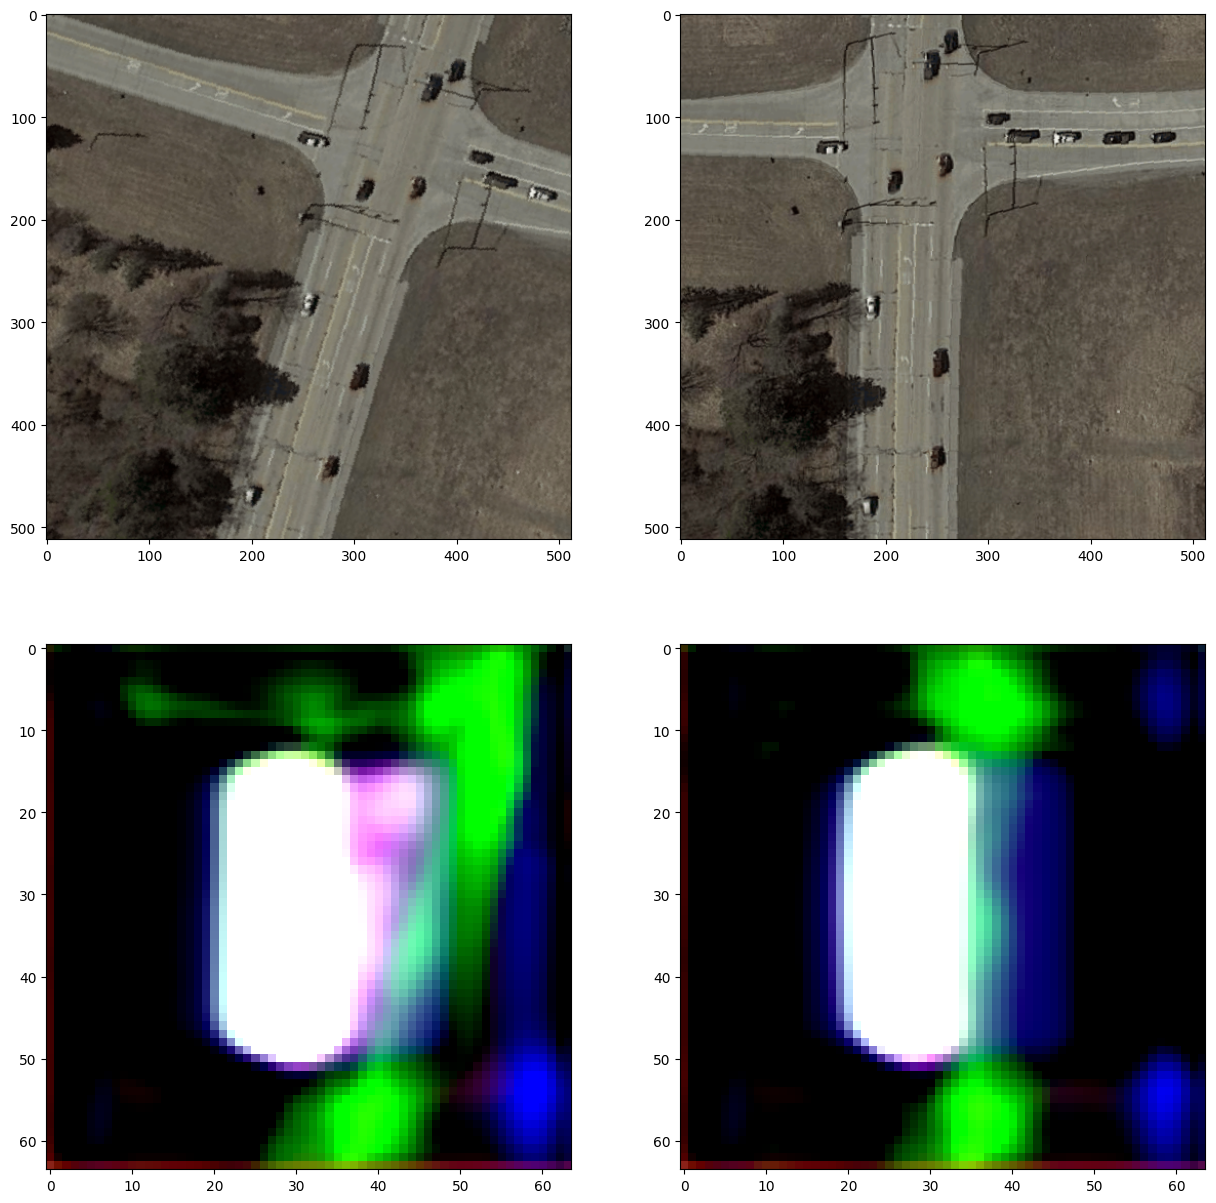

In [102]:
idx = 87 * 3


with torch.no_grad():
    x = model.img_encoder(torch.cat((sat_img_no_rot, sat_img), dim = 0))
    img1 = x[0].permute([1,2,0])[:,:,idx:idx+3].cpu()
    img2 = x[1].permute([1,2,0])[:,:,idx:idx+3].cpu()


print(x.shape)
plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
plt.imshow(sat_img[0].cpu().permute([1,2,0]), cmap='hot')


plt.subplot(2,2,2)
plt.imshow(sat_img_no_rot[0].cpu().permute([1,2,0]) , cmap='hot')


plt.subplot(2,2,3)
plt.imshow(img2)

plt.subplot(2,2,4)
plt.imshow(img1)